# A TUTORIAL ON STOCHASTIC ALGORITHMS FOR UNCONSTRAINED, CONTINUOUS-VALUED OPTIMIZATION

by Sebastian T. Glavind, May, 2021

In [1]:
import numpy as np
import scipy.stats as ss
import scipy.optimize as opt
from matplotlib import pyplot as plt
%matplotlib inline

# import scipy.special as ssp
# import seaborn as sns
# import pandas as pd
# import pickle

# Introduction

In this tutorial, we will study a set of stochastic algorithms, including population methods, for unconstraint, continuous-valued optimization, namely stochastic gradient decent, stochastic hill-climbing, simulated annealing, genetic algorithms, and particle swarm optimization. For a reference on the algorithms, see e.g. Luke(2013), Kochenderfer&Wheeler(2019) and Russell&Norvig(2021).

***
Kochenderfer, M. J., & Wheeler, T. A. (2019). Algorithms for optimization. Mit Press.

Russell, S., & Norvig, P. (2021). Artificial intelligence: a modern approach.

Luke, S. (2013). Essentials of Metaheuristics.
***

# Objective functions

We will start out by considering the following simple, convex objective function:

$$ f(\mathbf{x}) = f(x_1, ..., x_n) = \sum_{i=1}^n x_i^2,$$

and then continue to study the Ackley function:

$$ f(\textbf{x}) = - a \exp( -b \sqrt{ \frac{1}{n} \sum_{i=1}^{n} x_i^2} ) - \exp( \frac{1}{n} \sum_{i=1}^{n} \cos(c x_i)) + a + \exp(1), $$

where the values $a$, $b$ and $c$ are constants, which are usually chosen to be $a=20$, $b=0.2$ and $c=2\pi$. This function is a common benchmark problem in optimization, with global optima at $f(\mathbf{0})=0$.

In order to study the optimization graphically, we will consider both functions in two-dimensional space;

In [2]:
###########################################################################
# Objective functions and corresponding gradients
###########################################################################

# objective function A: Quadratic function
def objective_a(xx):
    x1, x2 = xx[0], xx[1]    
    # Output
    return( x1**2 + x2**2 )

def gradient_a(xx):
    x1, x2 = xx[0], xx[1]  
    # Output
    return( np.asarray([ 2*x1, 2*x2 ]) )

def hessian_a(xx): 
    # Note that no input is needed in this case as the hessian only includes constant terms
    # Output
    return( np.array([[2,0],[0,2]]) )


# # objective function B: Ackley function
# https://en.wikipedia.org/wiki/Ackley_function
# https://machinelearningmastery.com/how-to-use-nelder-mead-optimization-in-python/
def objective_b(xx):
    x1, x2 = xx[0], xx[1] 
    a = 20; b = 0.2; c = 2*np.pi;
    # Output
    return( -a * np.exp(-b * np.sqrt(0.5 * (x1**2 + x2**2))) - np.exp(0.5 * (np.cos(c * x1) + np.cos(c * x2))) + a + np.exp(1) )

def gradient_b(xx):
    x1, x2 = xx[0], xx[1] 
    a = 20; b = 0.2; c = 2*np.pi;	
    # Gradients
    g_x1 = (0.5 * a * b * x1 * np.exp( -b * np.sqrt( 0.5*x1**2 + 0.5*x2**2 ) ) )/np.sqrt( 0.5*x1**2 + 0.5*x2**2 ) + 0.5 * c * np.sin( c * x1) * np.exp( 0.5 * np.cos( c * x1) + 0.5 * np.cos( c * x2) )
    g_x2 = (0.5 * a * b * x2 * np.exp( -b * np.sqrt( 0.5*x1**2 + 0.5*x2**2 ) ) )/np.sqrt( 0.5*x1**2 + 0.5*x2**2 ) + 0.5 * c * np.sin( c * x2) * np.exp( 0.5 * np.cos( c * x1) + 0.5 * np.cos( c * x2) )
    # Output
    return( np.asarray([ g_x1, g_x2 ]) )


###########################################################################
# Plotting function for objective function 
###########################################################################

def objective_plot(xx_grid, obj_grid, plot_title):
    # create a surface plot with the jet color scheme
    fig = plt.figure(figsize=(16,6))
    fig.subplots_adjust(wspace=0.3)

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(xx_grid[0], xx_grid[1], obj_grid, cmap='jet')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$f$')

    ax = fig.add_subplot(1, 2, 2)
    con = ax.contourf(xx_grid[0], xx_grid[1], obj_grid, levels=50, cmap='jet')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_aspect('equal')

    # Add colorbar and title
    fig.subplots_adjust(right=0.8)
    cbar = fig.colorbar(con)
    cbar.ax.set_ylabel('$f$')
    fig.suptitle(plot_title, fontsize=13, y=0.95)

    # show the plot
    plt.show()

## Objective function A

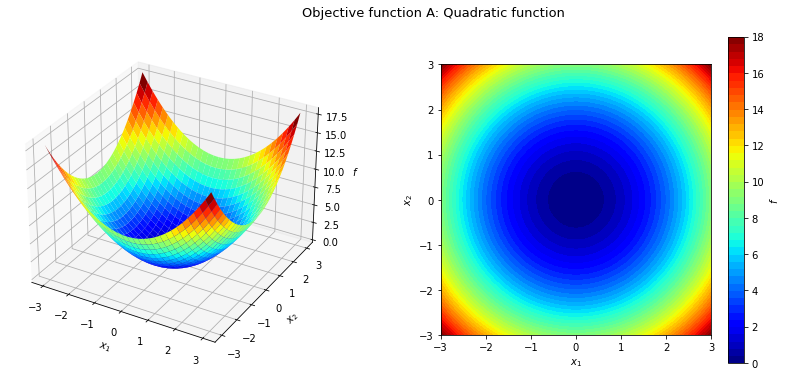

In [3]:
# define range for input
r_obj_a = np.array([-3.0, 3.0])
# sample input range uniformly at 0.1 increments
xstep_a = 0.1
xaxis_a = np.arange(r_obj_a[0], r_obj_a[1]+xstep_a, xstep_a)
# create a mesh from the axis
xx_a = np.meshgrid(xaxis_a, xaxis_a)
# compute targets
eval_obj_a = objective_a(xx_a)    
# Plot
objective_plot(xx_a, eval_obj_a, 'Objective function A: Quadratic function')

## Objective function B

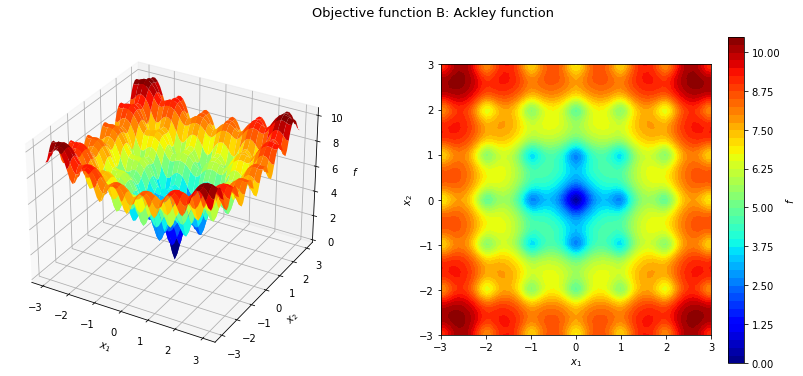

In [4]:
# create a mesh from the axis
xx_b = xx_a
# compute targets
eval_obj_b = objective_b(xx_b)    
# Plot
objective_plot(xx_b, eval_obj_b, 'Objective function B: Ackley function')

# Stochastic gradient decent

This algorithm and its extensions are commonly used to fit modern deep learning models. Stochasticity comes into the picture, as the gradient at each iteration is approximated using only a subset of the data, called minibatches, to reduce the computational burden compared to using the entire data set in the approximation of the gradients.

A stochastic variant of gradient decent may also be defined by introducing a small Gaussian perturbation to the decent direction at each iteration. To guarantee convergence, the step size needs to decrease with the number of iterations $k$, and the noise standard deviation of the Gaussian perturbation is usually set to $1/k$, see Kochenderfer&Wheeler(2019).

In [5]:
###########################################################################
# Gradient decent with decaying step factor
###########################################################################

def SGD_AjustDecay(f_obj, g_obj, xv0, alpha0, gamma0, kmax=100, precision=1e-8):
    xv = xv0
    obj = f_obj(xv)
    # book keeping
    xTrace = list(); xTrace.append(xv.copy())
    objTrace = list(); objTrace.append(obj.copy())
    for k in range(kmax):
        g_k = g_obj(xv) # gradient
        d_k = - g_k / np.sqrt(np.dot(g_k, g_k)) # search dir. - normalize gradient to length 1, see Kochenderfer & Wheelser (2019; Eq. 5.2)
        alpha_k = alpha0 * gamma0**(k) # decaying step factor, see Kochenderfer & Wheelser (2019; Eq. 4.3)
        if k < round(kmax/2): #Kochenderfer & Wheelser (2019; page 125, reference 2) - we may stop the noise addition at some point (not needed) 
            eta_k = np.random.randn(len(xv))/(k+1) # random Gaussian perturbation
        else:
            eta_k = 0
        xv +=  alpha_k * d_k + eta_k 
        obj = f_obj(xv)
#         print('Iteration %d: f(%s) = %.5f' % (k, xv, obj))
        # book keeping
        xTrace.append(xv.copy())
        objTrace.append(obj.copy())
        # convergance (early stopping)
        if abs( objTrace[k+1] - objTrace[k] ) <= precision:
               break
    # Output    
    return(xTrace, objTrace)

###########################################################################
# Plotting function
###########################################################################
def GD_plotting_function(xx_grid, obj_grid, x_bgd, obj_bgd, plot_title):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13.5,6), gridspec_kw={'width_ratios': [1, 1.2]})
    # fig_a.subplots_adjust(wspace=0.1)
    n = x_bgd.shape[0]-1
    
    ax1.plot(obj_bgd)
    ax1.set_ylim([0,max(obj_bgd)])
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Objective')

    con = ax2.contourf(xx_grid[0], xx_grid[1], obj_grid, levels=50, cmap='jet')
    ax2.plot(x_bgd[:, 0], x_bgd[:, 1], '.-', color='w')
    ax2.plot(x_bgd[n, 0], x_bgd[n, 1], 'o', color='k', markersize=10)
    # ax_a2.plot(x_bgs_decay[3, 0], x_bgs_decay[3, 1], 'o', color='r', markersize=10)
    ax2.set_xlim([-3,3])
    ax2.set_ylim([-3,3])
    ax2.set_xlabel('$x_1$')
    ax2.set_ylabel('$x_2$')
    ax2.set_aspect('equal')

    # Add colorbar and title
    fig.subplots_adjust(right=0.8)
    cbar = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(con, cax=cbar)
    cbar.ax.set_ylabel('$f$')
    fig.suptitle(plot_title, fontsize=13, y=0.95)

    # show the plot
    plt.show()

## Results

### Objective function A

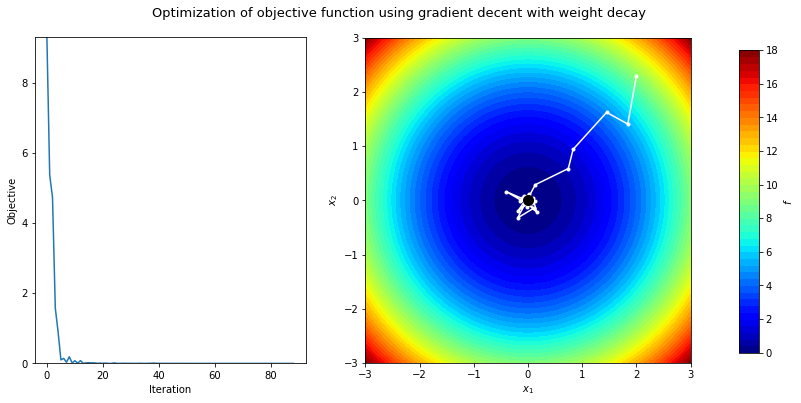

In [6]:
np.random.seed(42)

# Batch gradient decent with decaying step factor
x_a_sgd_decay, obj_a_sgd_decay = SGD_AjustDecay(objective_a, gradient_a, np.array([2.0,2.3]), 1.0, 0.9, 100)
x_a_sgd_decay = np.asarray(x_a_sgd_decay)

GD_plotting_function(xx_a, eval_obj_a, x_a_sgd_decay, obj_a_sgd_decay, 'Optimization of objective function using gradient decent with weight decay')

### Objective function B

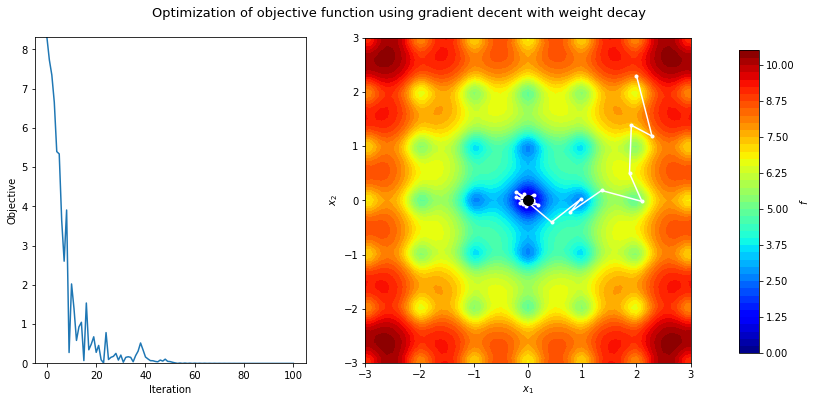

In [7]:
np.random.seed(42)

# Batch gradient decent with decaying step factor
x_b_sgd_decay, obj_b_sgd_decay = SGD_AjustDecay(objective_b, gradient_b, np.array([2.0,2.3]), 1.0, 0.9, 100)
x_b_sgd_decay = np.asarray(x_b_sgd_decay)

GD_plotting_function(xx_b, eval_obj_b, x_b_sgd_decay, obj_b_sgd_decay, 'Optimization of objective function using gradient decent with weight decay')

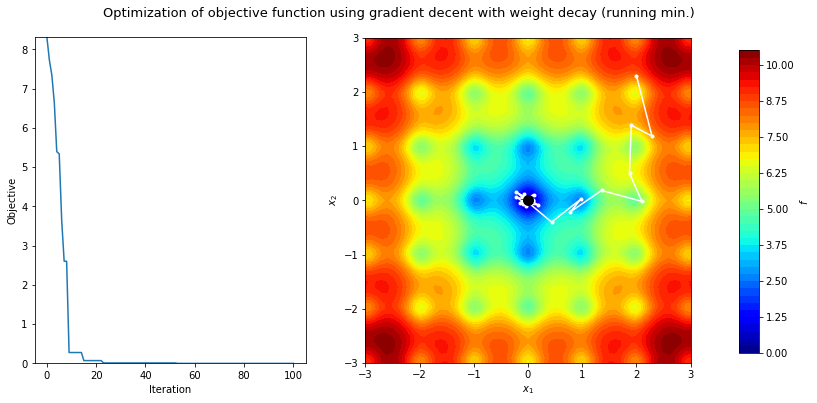

In [8]:
# Plotted as running min
GD_plotting_function(xx_b, eval_obj_b, x_b_sgd_decay, np.minimum.accumulate(np.asarray(obj_b_sgd_decay)), 'Optimization of objective function using gradient decent with weight decay (running min.)')

# Stochastic hill-climbing

Hill-climbing algorithms are found in different variants and can be used for both continuous and discrete optimization. In either case, a notion of neighborhood is needed. For discrete optimization, a neighborhood is commonly defined as the finite set of solutions that can be produced by local perturbations to the current solution, and the solution in the neighborhood resulting in the minimum objective value is chosen. For continuous optimization, i.e., the focus this tutorial, a neighborhood is commonly defined by making random perturbations to the current solution, and again solution in the neighborhood resulting in the minimum objective value is chosen.

In [9]:
###########################################################################
# Stochastic hill-climbing search
###########################################################################

def SHC(f_obj, xv0, alpha0, kmax=100, precision=1e-8):
    xv = xv0
    obj = f_obj(xv)
    # book keeping
    xTrace = list(); xTrace.append(xv.copy())
    objTrace = list(); objTrace.append(obj.copy())
    for k in range(kmax):
        xv = xTrace[k] + np.random.randn(len(xv)) * alpha0
        obj = f_obj(xv)
#         print('Iteration %d: f(%s) = %.5f' % (k, xv, obj))
        # book keeping
        if obj <= objTrace[k]:
            xTrace.append(xv.copy())
            objTrace.append(obj.copy())
        else:
            xTrace.append(xTrace[k].copy())
            objTrace.append(objTrace[k].copy())
        # convergance (early stopping)
#         if k > 10:
#             if objTrace[k+1] == objTrace[k-8]: # terminate after 5 iterations without improvements
#                    break
    # Output    
    return(xTrace, objTrace)

## Results

### Objective function A

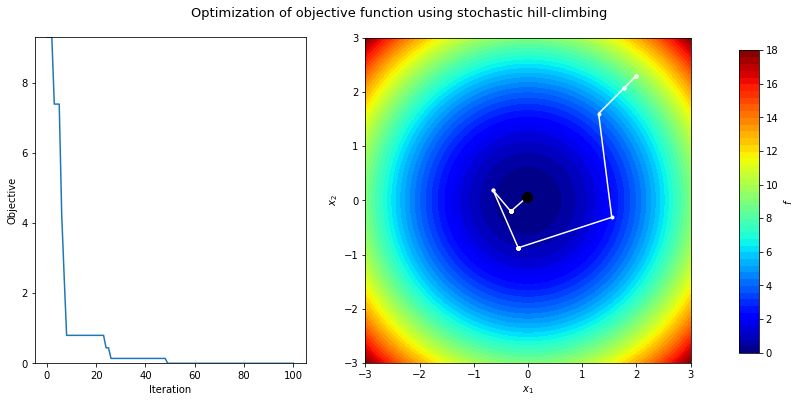

In [10]:
np.random.seed(42)

# Batch gradient decent with decaying step factor
x_a_shc, obj_a_shc = SHC(objective_a, np.array([2.0,2.3]), 1.0, 100)
x_a_shc = np.asarray(x_a_shc)

GD_plotting_function(xx_a, eval_obj_a, x_a_shc, obj_a_shc, 'Optimization of objective function using stochastic hill-climbing')

### Objective function B

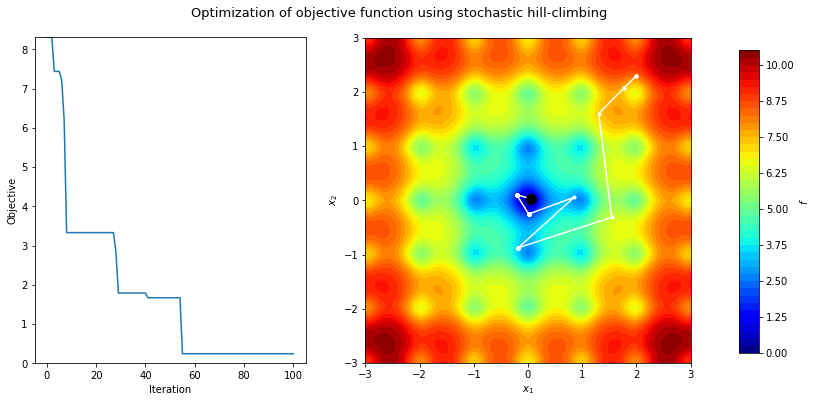

In [11]:
np.random.seed(42)

# Batch gradient decent with decaying step factor
x_b_shc, obj_b_shc = SHC(objective_b, np.array([2.0,2.3]), 1.0, 100)
x_b_shc = np.asarray(x_b_shc)

GD_plotting_function(xx_b, eval_obj_b, x_b_shc, obj_b_shc, 'Optimization of objective function using stochastic hill-climbing')

# Simulated annealing

Simulated annealing is similar to hill-climbing but varies in the decision of when to replace the current solution with a candidate solution. Specifically, if a candidate solution is better than current solution, we will accept the candidate solution, as in hill-climbing, but if the candidate solution is worse than the current solution, we will still accept the candidate solution with some probability (Metropolis acceptance criteria).

In [12]:
###########################################################################
# Stochastic hill-climbing search
###########################################################################

def SimAnnealing(f_obj, xv0, alpha0, temp0, kmax=100, precision=1e-8):
    xv = xv0
    obj = f_obj(xv)
    # book keeping
    xTrace = list(); xTrace.append(xv.copy())
    objTrace = list(); objTrace.append(obj.copy())
    for k in range(kmax):
        xv = xTrace[k] + np.random.randn(len(xv)) * alpha0
        obj = f_obj(xv)
#         print('Iteration %d: f(%s) = %.5f' % (k, xv, obj))
        diff = obj - objTrace[k]
        temp = temp0/(k+1) # fast annealing, alternative: temp1 = gamma * temp0, where gamma \in [0,1]
        # book keeping
        if diff <= 0 or np.random.rand() < np.exp(-diff/temp):
            xTrace.append(xv.copy())
            objTrace.append(obj.copy())
        else:
            xTrace.append(xTrace[k].copy())
            objTrace.append(objTrace[k].copy())
        # convergance (early stopping)
#         if k > 10:
#             if objTrace[k+1] == objTrace[k-8]: # terminate after 5 iterations without improvements
#                    break
    # Output    
    return(xTrace, objTrace)

## Results

### Objective function A

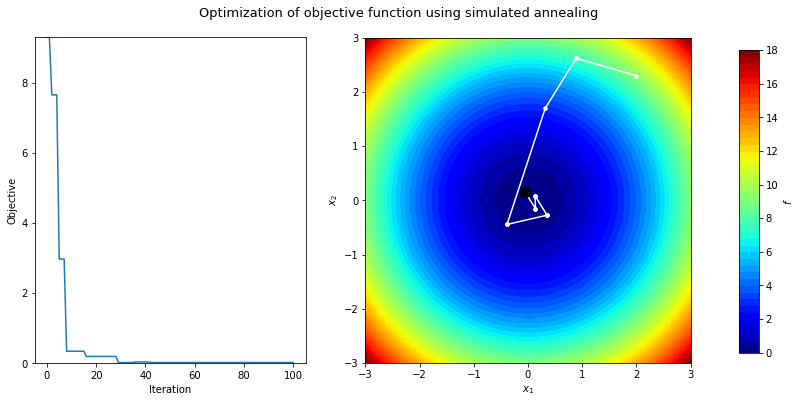

In [13]:
np.random.seed(42)

# Simulated annealing
x_a_simAnn, obj_a_simAnn = SimAnnealing(objective_a, np.array([2.0,2.3]), 1.0, 1.0, 100)
x_a_simAnn = np.asarray(x_a_simAnn)

GD_plotting_function(xx_a, eval_obj_a, x_a_simAnn, obj_a_simAnn, 'Optimization of objective function using simulated annealing')

### Objective function B

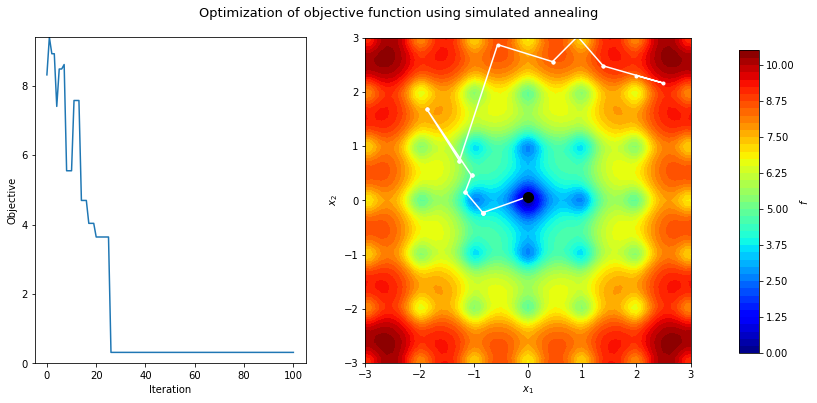

In [14]:
np.random.seed(42)

# Batch gradient decent with decaying step factor
x_b_simAnn, obj_b_simAnn = SimAnnealing(objective_b, np.array([2.0,2.3]), 1.0, 10.0, 100)
x_b_simAnn = np.asarray(x_b_simAnn)

GD_plotting_function(xx_b, eval_obj_b, x_b_simAnn, obj_b_simAnn, 'Optimization of objective function using simulated annealing')

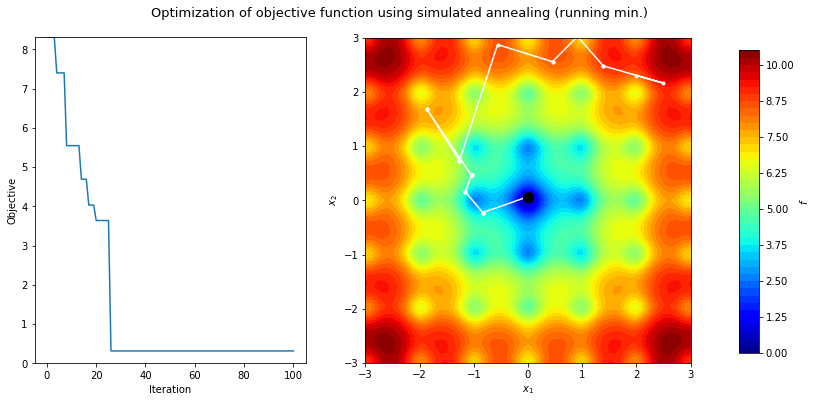

In [15]:
# Plotted as running min
GD_plotting_function(xx_b, eval_obj_b, x_b_simAnn, np.minimum.accumulate(np.asarray(obj_b_simAnn)), 'Optimization of objective function using simulated annealing (running min.)')

# Genetic algorithm

The genetic algorithm is a stochastic global optimization algorithm that is inspired by biologically. First, "individuals" (data points) are sampled over-dispersed in the sample space, and then fitter individuals are more likely to pass on their "genes" in supsequent iterations. In each iteration, three steps are performed: (i) selection, (ii) crossover, and (iii) mutation. The mutation step makes the algorithm less dependent on the initial sample of individuals.

In [16]:
###########################################################################
# Initialization - random designs
###########################################################################
def random_design_uniform(n, a, b):
    m = len(a)
    xm = a + np.random.uniform(0,1,(n,m))*(b-a)
    return(xm)

def random_design_gaussian(n, mu, sig):
    m = len(mu)
    xm = mu + np.random.normal(0,1,(n,m))*sig
    return(xm)

def random_design_cauchy(n, loc, scale, seed=1):
    m = len(loc)
    xm = ss.cauchy.rvs(loc=loc, scale=scale, size=(n,m), random_state=seed)
    return(xm)

###########################################################################
# Selection
###########################################################################
def selection_truncation(y, k=None):
    n = len(y)
    if k==None: 
        k=n//10 # integer
    index_y_sorted = np.argsort(y)
    index = np.random.choice(index_y_sorted[:k], size=(n,2), replace=True)
    return(index)

def selection_turnament(y, k=None):
    n = len(y)
    if k==None: 
        k=n//10 # integer
    index = np.zeros((n,2), dtype=int)
    for t in range(3):
        ind_t = np.random.randint(low=0, high=n, size=(k,2)); # print(ind_t); print(y[ind_t[:,0]]); print(y[ind_t[:,1]])
        ind_t_min = np.array([np.argmin(y[ind_t[:,0]]), np.argmin(y[ind_t[:,1]])]); # print(ind_t_min)
        index[t,:] = np.array([ ind_t[ind_t_min[0],0], ind_t[ind_t_min[1],1] ]); # print(index[t,:], np.array([y[index[t,0]], y[index[t,1]]]))
    return(index)

def selection_roulette(y):
    n = len(y)
    p = np.max(y)-y + 1e-16; #print(p) 
    p = p/np.sum(p); #print(p)
    index = np.random.choice(np.arange(n), size=(n,2), replace=True, p=p); # print(y[index[:,0]], y[index[:,1]])
    return(index)

def isinteger(x):
    return(np.equal(np.mod(x, 1), 0))

###########################################################################
# Crossover
###########################################################################

def crossover_uniform(index, xm):
    n, m = index.shape
    index_cross = index[:,0] # basis is first parent
    xm_cross = xm[index_cross,:]
    for t in range(m):
        ind_t = np.random.randint(low=0, high=2, size=n) # ones are exchanged with second parent
        xm_cross[ind_t==1,t] = xm[index[ind_t==1,1],t]
    return(xm_cross)

def crossover_linear(index, xm, lam=0.5):
    xm_cross = (1-lam)*xm[index[:,0],:] + lam*xm[index[:,1],:];
    return(xm_cross)

###########################################################################
# Mutation
###########################################################################
def mutation_gaussian_noise(xm, sig):
    n, m = xm.shape
    xm_mutate = xm + np.random.normal(0,1,(n,m))*sig
    return(xm_mutate)

###########################################################################
# Genetic algorithm
###########################################################################
def GA(f_obj, f_select, f_crossover, f_mutation, xm0, std_factor=0.1, kmax=100, precision=1e-8):
    # book keeping
    xTrace = list(); 
    objTrace = list(); 
    for k in range(kmax):
        if (k == 0):
            xm = xm0
        else:
            # GA operations
            index = f_select(yv)
            xm_cross = f_crossover(index, xm)
            xm = f_mutation(xm_cross, std_factor*np.std(xm_cross, axis=0)) # note that this is a function of the input variance
        yv = f_obj(list([xm[:,0], xm[:,1]]))
        
        # book keeping
        xTrace.append(xm.copy())
        objTrace.append(yv.copy())
        
    # Output    
    return(xTrace, objTrace)

###########################################################################
# Plotting function for objective function 
###########################################################################
def GA_plotting_function(xx_grid, obj_grid, xm, ind01=1, ind10=2, xLim=[-3.0, 3.0], yLim=[-3.0, 3.0]):
    n = len(xm)
    # plot design
    fig, axs = plt.subplots(2, 2, figsize=(14.4,10))
    con = axs[0, 0].contourf(xx_grid[0], xx_grid[1], obj_grid, levels=50, cmap='jet')
    axs[0, 0].scatter(xm[0][:,0], xm[0][:,1], marker='x', c='w', label='Initial samples')
    axs[0, 0].legend(loc='upper right')
    axs[0, 1].contourf(xx_grid[0], xx_grid[1], obj_grid, levels=50, cmap='jet')
    axs[0, 1].scatter(xm[ind01][:,0], xm[ind01][:,1], marker='x', c='w', label='Iteration '+str(ind01))
    axs[0, 1].legend(loc='upper right')
    axs[1, 0].contourf(xx_grid[0], xx_grid[1], obj_grid, levels=50, cmap='jet')
    axs[1, 0].scatter(xm[ind10][:,0], xm[ind10][:,1], marker='x', c='w', label='Iteration '+str(ind10))
    axs[1, 0].legend(loc='upper right')
    axs[1, 1].contourf(xx_grid[0], xx_grid[1], obj_grid, levels=50, cmap='jet')
    axs[1, 1].scatter(xm[n-1][:,0], xm[n-1][:,1], marker='x', c='w', label='Iteration '+str(n-1))
    axs[1, 1].legend(loc='upper right')

    for ax in axs.flat:
        ax.set(xlim=xLim, ylim=yLim, xlabel='$x_1$', ylabel='$x_2$', aspect='equal')

    # Add colorbar and title
    fig.subplots_adjust(right=0.8)
    cbar = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(con, cax=cbar)
    cbar.ax.set_ylabel('$f$')

    # show the plot
    plt.show()

## Results

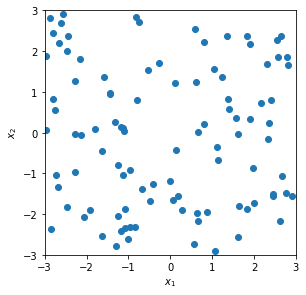

In [17]:
np.random.seed(42)

# random design
xm0_ga = random_design_uniform(n=100, a=np.array([-3.0,-3.0]), b=np.array([3.0,3.0]))
# xm0_ga = random_design_gaussian(n=100, mu=np.array([1,100]), sig=np.array([5,30]))
# xm0_ga = random_design_cauchy(n=100, loc=np.array([0,0]), scale=np.array([1,1]), seed=1)

# plot design
plt.figure(figsize=(4.5,4.5))
plt.scatter(xm0_ga[:,0], xm0_ga[:,1])
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

### Objective function A

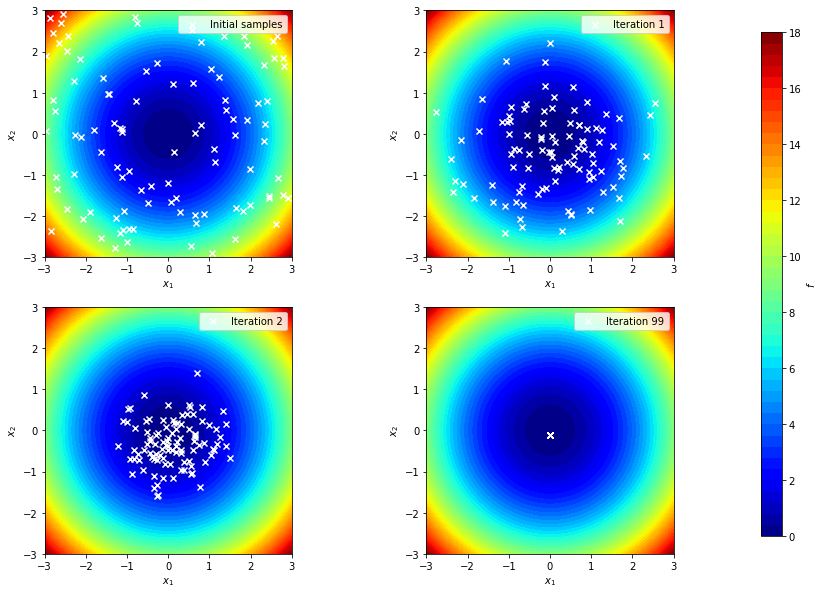

In [18]:
# Genetic algorithm
xm_a_ga, obj_a_ga = GA(objective_a, selection_roulette, crossover_linear, mutation_gaussian_noise, xm0_ga)

# Plot results
GA_plotting_function(xx_a, eval_obj_a, xm_a_ga)

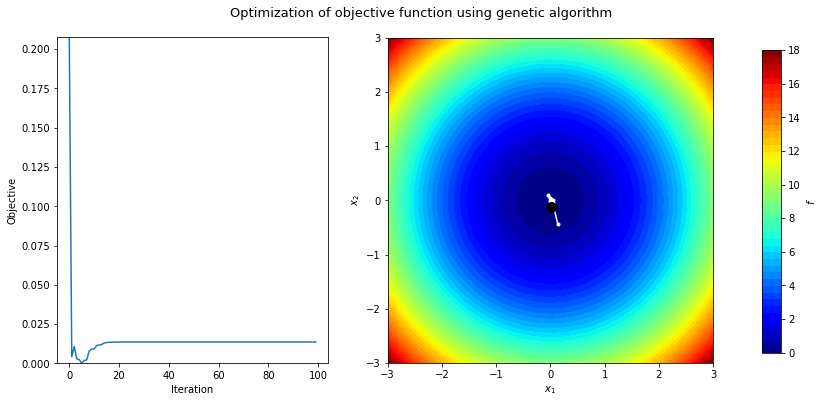

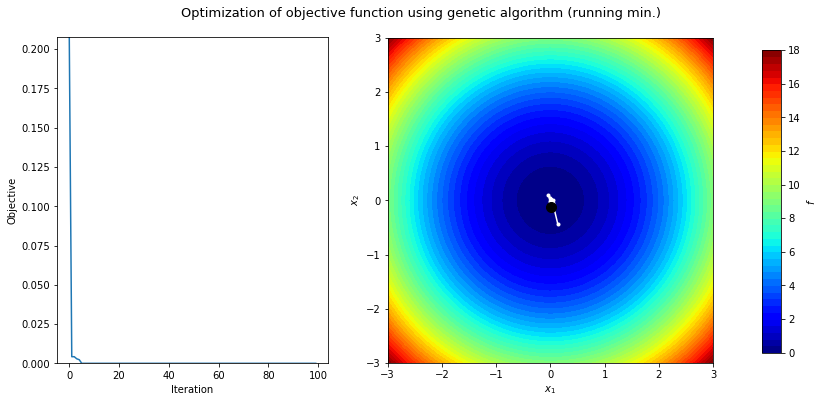

In [19]:
n_ga = xm0_ga.shape[0]

ymin_a_ga = np.zeros((n_ga))
xmin_a_ga = np.zeros((n_ga,2))
for i in range(n_ga):
    ind_min_i = np.argmin(obj_a_ga[i])
    ymin_a_ga[i] = obj_a_ga[i][ind_min_i]
    xmin_a_ga[i,:] = xm_a_ga[i][ind_min_i,:]

# Best result per iteration
GD_plotting_function(xx_a, eval_obj_a, xmin_a_ga, ymin_a_ga, 'Optimization of objective function using genetic algorithm')

# Plotted as running min
GD_plotting_function(xx_a, eval_obj_a, xmin_a_ga, np.minimum.accumulate(np.asarray(ymin_a_ga)), 'Optimization of objective function using genetic algorithm (running min.)')

### Objective function B

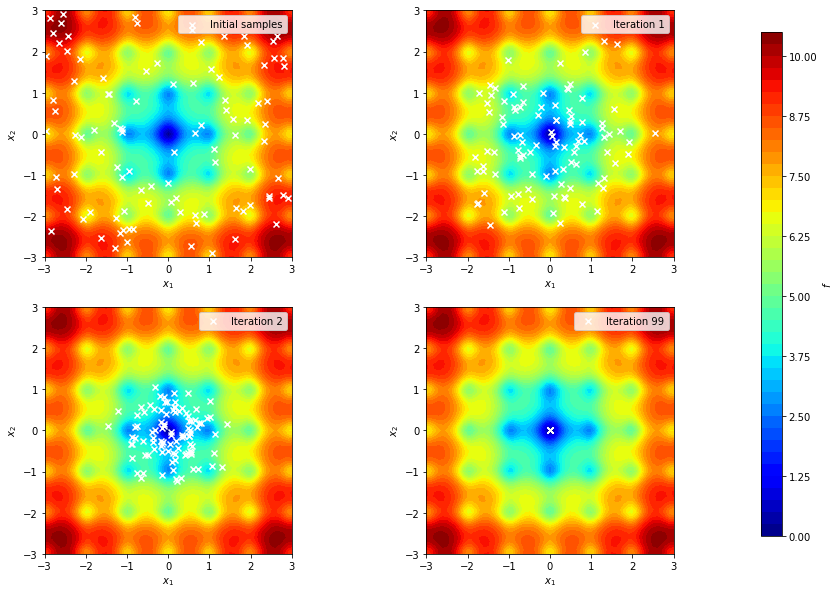

In [20]:
# Genetic algorithm
xm_b_ga, obj_b_ga = GA(objective_b, selection_roulette, crossover_linear, mutation_gaussian_noise, xm0_ga)

# Plot results
GA_plotting_function(xx_b, eval_obj_b, xm_b_ga)

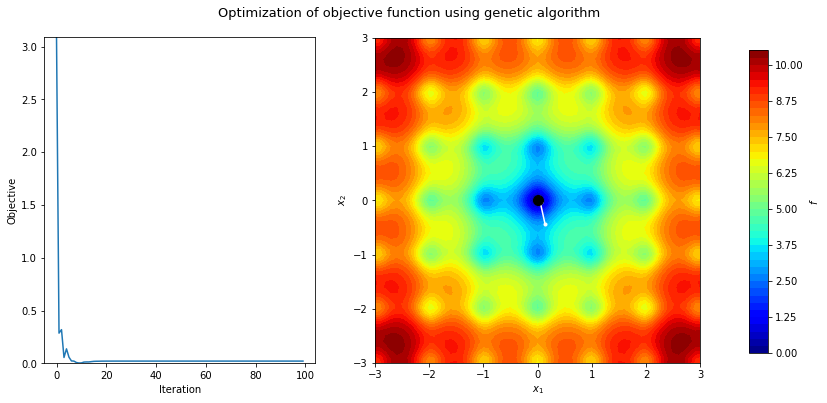

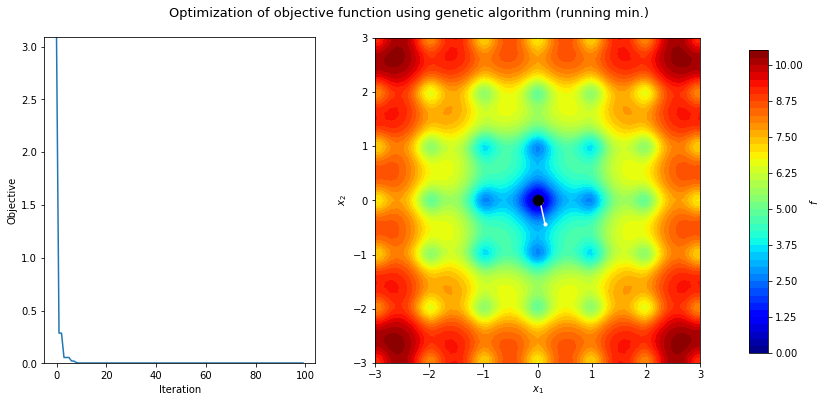

In [21]:
ymin_b_ga = np.zeros((n_ga))
xmin_b_ga = np.zeros((n_ga,2))
for i in range(n_ga):
    ind_min_i = np.argmin(obj_b_ga[i])
    ymin_b_ga[i] = obj_b_ga[i][ind_min_i]
    xmin_b_ga[i,:] = xm_b_ga[i][ind_min_i,:]
    
# Best result per iteration
GD_plotting_function(xx_b, eval_obj_b, xmin_b_ga, ymin_b_ga, 'Optimization of objective function using genetic algorithm')

# Plotted as running min
GD_plotting_function(xx_b, eval_obj_b, xmin_b_ga, np.minimum.accumulate(np.asarray(ymin_b_ga)), 'Optimization of objective function using genetic algorithm (running min.)')

# Particle swarm optimization

Particle swarm optimization (PSO) introduces momentum to make the search more targeted favorable regions and thus accelerate convergence. In this regard, the velocity of the individual particles, or individuals, is composed of (i) a persistence term, (ii) a term that directs the search towards the best objective value seen thus far by that particle, and (iii) a term that directs the search towards the best value seen thus far by any particle in the swarm, or population.

In [22]:
###########################################################################
# Particle swarm optimization
###########################################################################
def PSO_AjustDecay(f_obj, xm0, c1=1.0, c2=1.0, w0=1.0, gamma0=0.9, kmax=100, precision=1e-8):
    # initialization
    xm = xm0.copy()
    yv = f_obj(list([xm[:,0], xm[:,1]]))
    n, m = xm.shape
    yv_best = yv.copy(); ind_best = np.argmin(yv_best); ybest = yv_best[ind_best]; 
    xm_best = xm.copy(); xbest = xm_best[ind_best,:]
    # book keeping
    xTrace = list(); xTrace.append(xm.copy())
    objTrace = list(); objTrace.append(yv.copy())
    # updating loop
    for k in range(kmax):
        w_k = w0 * gamma0**(k) # decaying step factor, see Kochenderfer & Wheelser (2019; Eq. 4.3), which is recommended on p. 159. 
        if (k == 0):
            vv = 0 
        
        # update realizations
        rr = np.random.uniform(size=(n,2)); #print(rr)
        vv = w_k*vv + c1*rr[:,0].reshape(-1,1)*(xm_best - xm) + c2*rr[:,1].reshape(-1,1)*(xbest - xm); #print(vv) # momentum
        xm += vv; # print(xm)
        yv = f_obj(list([xm[:,0], xm[:,1]]))
        
        # update best objective values
        indv_best = (yv < yv_best)
        if sum(indv_best) > 0:
            yv_best[indv_best] = yv[indv_best]
            xm_best[indv_best,:] = xm[indv_best]
            ind_best = np.argmin(yv_best)
            ybest = yv_best[ind_best]
            xbest = xm_best[ind_best,:]

        # book keeping
        xTrace.append(xm.copy())
        objTrace.append(yv.copy())
        
    # Output    
    return(xTrace, objTrace)

## Results

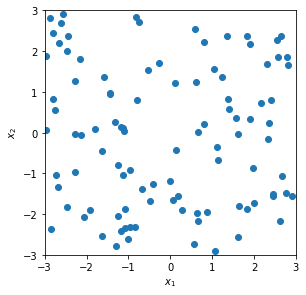

In [23]:
np.random.seed(42)

# random design
xm0_pso = random_design_uniform(n=100, a=np.array([-3.0,-3.0]), b=np.array([3.0,3.0]))
# xm0_ga = random_design_gaussian(n=100, mu=np.array([1,100]), sig=np.array([5,30]))
# xm0_ga = random_design_cauchy(n=100, loc=np.array([0,0]), scale=np.array([1,1]), seed=1)

# plot design
plt.figure(figsize=(4.5,4.5))
plt.scatter(xm0_pso[:,0], xm0_pso[:,1])
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

### Objective A

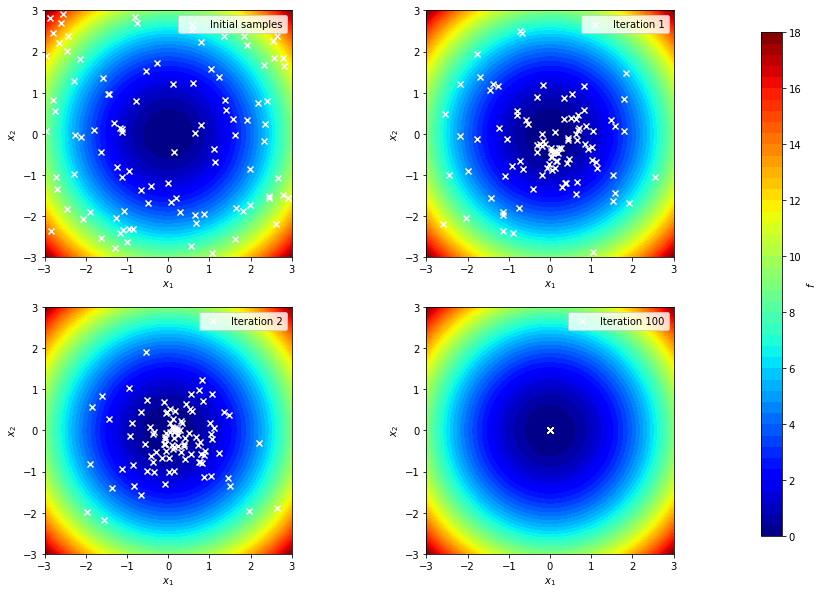

In [24]:
# Particle swarm optimization
xm_a_pso, obj_a_pso = PSO_AjustDecay(objective_a, xm0_pso)

# Plot results
GA_plotting_function(xx_a, eval_obj_a, xm_a_pso)

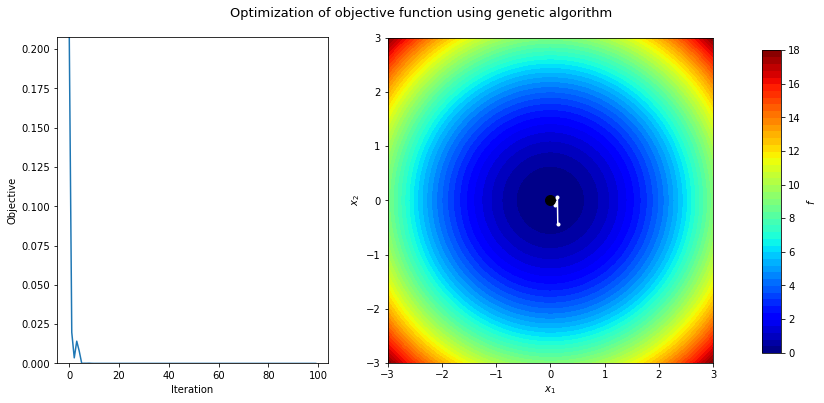

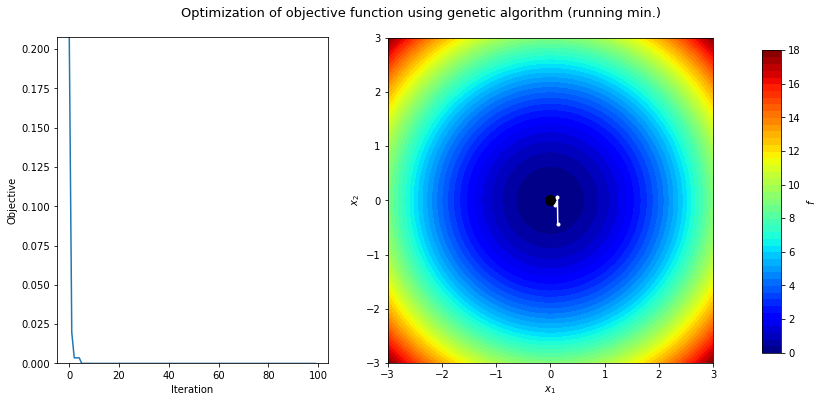

In [25]:
n_pso = xm0_pso.shape[0]

ymin_a_pso = np.zeros((n_pso))
xmin_a_pso = np.zeros((n_pso,2))
for i in range(n_ga):
    ind_pso_i = np.argmin(obj_a_pso[i])
    ymin_a_pso[i] = obj_a_pso[i][ind_pso_i]
    xmin_a_pso[i,:] = xm_a_pso[i][ind_pso_i,:]

# Best result per iteration
GD_plotting_function(xx_a, eval_obj_a, xmin_a_pso, ymin_a_pso, 'Optimization of objective function using genetic algorithm')

# Plotted as running min
GD_plotting_function(xx_a, eval_obj_a, xmin_a_pso, np.minimum.accumulate(np.asarray(ymin_a_pso)), 'Optimization of objective function using genetic algorithm (running min.)')

### Objective B

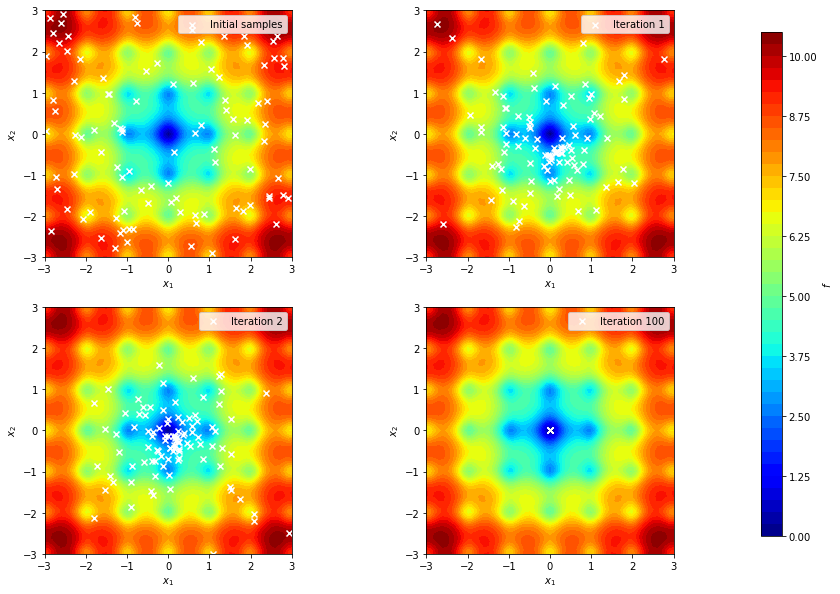

In [26]:
# Particle swarm optimization
xm_b_pso, obj_b_pso = PSO_AjustDecay(objective_b, xm0_pso)

# Plot results
GA_plotting_function(xx_b, eval_obj_b, xm_b_pso)

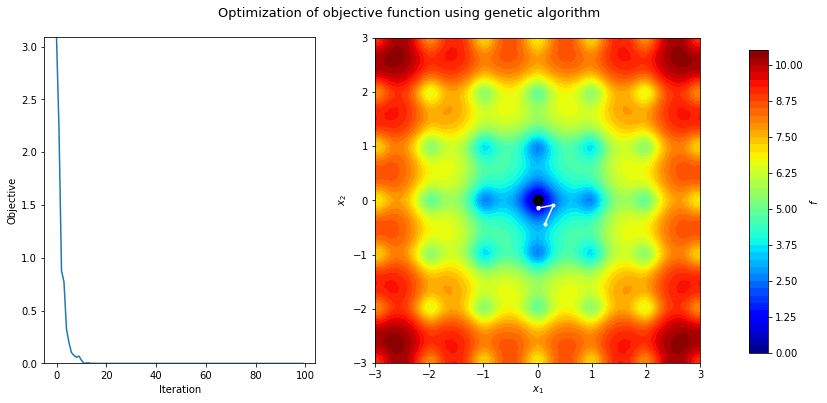

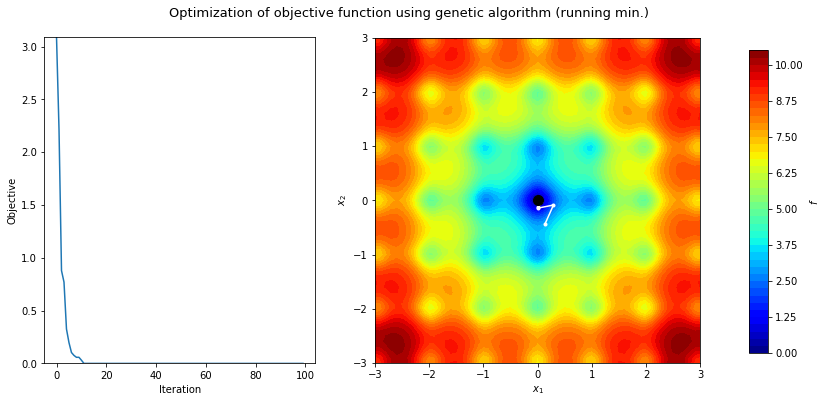

In [27]:
ymin_b_pso = np.zeros((n_pso))
xmin_b_pso = np.zeros((n_pso,2))
for i in range(n_ga):
    ind_pso_i = np.argmin(obj_b_pso[i])
    ymin_b_pso[i] = obj_b_pso[i][ind_pso_i]
    xmin_b_pso[i,:] = xm_b_pso[i][ind_pso_i,:]

# Best result per iteration
GD_plotting_function(xx_b, eval_obj_b, xmin_b_pso, ymin_b_pso, 'Optimization of objective function using genetic algorithm')

# Plotted as running min
GD_plotting_function(xx_b, eval_obj_b, xmin_b_pso, np.minimum.accumulate(np.asarray(ymin_b_pso)), 'Optimization of objective function using genetic algorithm (running min.)')